In [1]:
from scipy.integrate import quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum

%matplotlib inline

In [2]:
a = np.array([[1, 2],[3, 4]])
a = theano.shared(a)

b = T.vector('b')

f = T.dot(b, a)

f.eval({b: [1, 2]})
T.grad(f[1], [b])[0].eval({b: [1, 2]})

array([2., 4.])

In [3]:
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [4]:
## Basic usage

# We define the function we want to integrate
x = T.dscalar('x')
a = T.dscalar('a')

func = a ** 2 + x**2
integrate = Integrate(func, x, 1, 2, a)


# Now, we define values for the integral
a_ = T.dscalar('a_')

# Note, that a_ != a
val = integrate(a_)

# Evaluate the integral and derivatives
print(val.eval({a_: 2.}))
print(T.grad(val, a_).eval({a_: 2.}))
print(T.grad(val, a_).eval({a_: 8.}))
verify_grad(integrate, [0.])
verify_grad(integrate, [-2.])


6.333333333333334
4.0
16.0


In [5]:
def forward_fold_gammapy(amplitude, alpha, beta, observation):
    bin_mask = observation.on_vector.bins_in_safe_range
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
#     counts *= observation.on_vector.areascal
    return counts.value[bin_mask]

In [6]:
def forward_fold_log_parabola(amplitude, alpha, beta, observation, fit_range=None):

    obs_bins = observation.on_vector.energy
    aeff_bins = observation.aeff.energy
    e_reco_bins = observation.edisp.e_reco
    e_true_bins = observation.edisp.e_true
     
    if fit_range:
        lo = obs_bins.lo.min()
        hi = obs_bins.hi.max()
        lo = max(fit_range[0], lo).to_value(u.TeV)
        hi = min(fit_range[1], hi ).to_value(u.TeV)
    else:
        lo = obs_bins.lo.min().to_value(u.TeV)
        hi = obs_bins.hi.max().to_value(u.TeV)

    obs_mask = (obs_bins.lo.to_value(u.TeV) > lo ) & (obs_bins.hi.to_value(u.TeV) <= hi)
    aeff_mask = (aeff_bins.lo.to_value(u.TeV) > lo ) & (aeff_bins.hi.to_value(u.TeV) <= hi)
    e_reco_mask = (e_reco_bins.lo.to_value(u.TeV) > lo ) & (e_reco_bins.hi.to_value(u.TeV) <= hi)
    e_true_mask = (e_true_bins.lo.to_value(u.TeV) > lo ) & (e_true_bins.hi.to_value(u.TeV) <= hi)
    
    aeff = observation.aeff.data.data.to_value(u.cm**2)[aeff_mask]
    
    lower =  e_true_bins.lo[e_true_mask].to_value(u.TeV)
    upper = e_true_bins.hi[e_true_mask].to_value(u.TeV)

    def log_par(e):
        exponent =  -alpha - beta * np.log10(e)
        return amplitude * 1e-11 * e ** (exponent) 

    counts = [quad(log_par, l, u)[0] for l, u in zip(lower, upper)]
    
    counts *= aeff
    counts *= observation.livetime.to_value(u.s)
    
    edisp = observation.edisp.pdf_matrix[e_true_mask]
    
    return (counts @ edisp)[obs_mask]

In [7]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=None):

    obs_bins = observation.on_vector.energy
    aeff_bins = observation.aeff.energy
    e_reco_bins = observation.edisp.e_reco
    e_true_bins = observation.edisp.e_true
     
    if fit_range:
        lo = obs_bins.lo.min()
        hi = obs_bins.hi.max()
        lo = max(fit_range[0], lo).to_value(u.TeV)
        hi = min(fit_range[1], hi ).to_value(u.TeV)
    else:
        lo = obs_bins.lo.min().to_value(u.TeV)
        hi = obs_bins.hi.max().to_value(u.TeV)

    obs_mask = (obs_bins.lo.to_value(u.TeV) > lo ) & (obs_bins.hi.to_value(u.TeV) <= hi)
    aeff_mask = (aeff_bins.lo.to_value(u.TeV) > lo ) & (aeff_bins.hi.to_value(u.TeV) <= hi)
    e_reco_mask = (e_reco_bins.lo.to_value(u.TeV) > lo ) & (e_reco_bins.hi.to_value(u.TeV) <= hi)
    e_true_mask = (e_true_bins.lo.to_value(u.TeV) > lo ) & (e_true_bins.hi.to_value(u.TeV) <= hi)
    
   
    lower =  e_true_bins.lo[e_true_mask].to_value(u.TeV)
    upper = e_true_bins.hi[e_true_mask].to_value(u.TeV)

    amplitude *= 1e-11
    
    energy = T.dscalar('energy')
    amplitude_ = T.dscalar('amplitude_')
    alpha_ = T.dscalar('alpha_')
    beta_ = T.dscalar('beta_')

    func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))
    
    counts = []
    for a, b in zip(lower, upper):
        c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
        counts.append(c)

    counts = T.stack(counts)
    aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)[aeff_mask]
    aeff = T.constant(aeff)
    

    counts *= aeff
    counts *= theano.shared(observation.livetime.to_value(u.s))
#     return counts
    edisp = observation.edisp.pdf_matrix[e_true_mask]
    edisp = T.constant(edisp)
    
    return T.dot(counts, edisp)[observation.on_vector.bins_in_safe_range]

In [8]:
obs_list, fit_range = load_spectrum_observations('fact')
observation = obs_list[0]

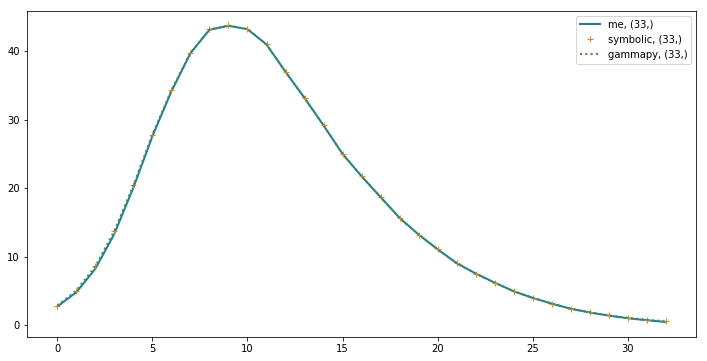

In [9]:
plt.figure(figsize=(12, 6))

counts = forward_fold_log_parabola(4, 2, 0.5, observation, fit_range=fit_range)
plt.plot(counts, label=f'me, {counts.shape}', lw=2)

amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
counts = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)
counts = counts.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})
plt.plot(counts, '+', label=f'symbolic, {counts.shape}')

counts = forward_fold_gammapy(4, 2, 0.5, observation)
plt.plot(counts, label=f'gammapy, {counts.shape}', ls=':', lw=2, )
plt.legend()


None

In [10]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
counts = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)
counts, counts.ndim, counts.shape.eval({amplitude: 4.0, alpha: 2.5, beta: 0.5})

(AdvancedSubtensor1.0, 1, array([33]))

In [11]:
g = T.grad(counts[20], [amplitude, alpha,  beta])

print(counts[20].eval({amplitude: 4.0, alpha: 2.5, beta: 0.5}))
d0 = g[0].eval({amplitude: 4.0, alpha: 2.5, beta: 0.5})
d1 = g[1].eval({amplitude: 4.0, alpha: 2.5, beta: 0.5})
d2 = g[2].eval({amplitude: 4.0, alpha: 2.5, beta: 0.5})

d0 != 0, d0, d1 != 0, d1, d2 != 0, d2

4.995838321299719


(True, array(1.24895958), True, array(-7.78475167), True, array(-5.53193981))

33


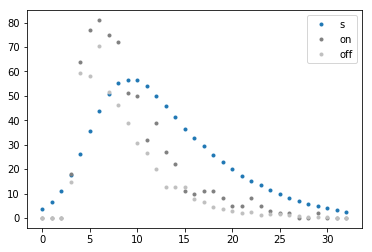

In [12]:

exposure_ratio = 0.2

mask = observation.on_vector.bins_in_safe_range
on_data = observation.on_vector.data.data[mask]
off_data = observation.off_vector.data.data[mask]

s = counts.eval({amplitude: 5.0, alpha: 2., beta: 0.2})

plt.plot(s, '.', label='s', )
plt.plot(on_data, '.', label='on', color='gray')
plt.plot(off_data * exposure_ratio, '.', label='off', color='silver')
# plt.plot(true_mu_s, '.',  label='true signal', color='crimson', ls='--', alpha=0.3)
# plt.plot(true_mu_s + exposure_ratio * true_mu_b, '.',  label='true s + b', color='orange', ls='--', alpha=0.3)
plt.legend()
print(len(on_data))

In [13]:
N_entries = len(on_data)
exposure_ratio = 0.2

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:
    
    amplitude = pm.HalfFlat('amplitude')
    alpha = pm.HalfFlat('alpha')
    beta = pm.HalfFlat('beta')
    
    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)
    
    mu_b = pm.HalfFlat('mu_b', shape=len(off_data))

    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio*b, observed=on_data)

In [14]:
# map_estimate = pm.find_MAP(model=model)
with model:
#     step = pm.Metropolis()
#     trace = pm.sample(100000, step=step, start=map_estimate)
    trace = pm.sample(1000)
    pm.traceplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, beta, alpha, amplitude]
Sampling 4 chains:   1%|▏         | 77/6000 [02:53<9:15:44,  5.63s/draws] 


ValueError: Not enough samples to build a trace.